In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [60]:
regres_data,regres_values = datasets.make_regression(n_samples=20, n_features = 2, n_informative = 2, 
                                                     
                                                       random_state=5)

In [61]:
regres_data

array([[-0.85685315, -0.98060789],
       [-0.42250793, -0.87187918],
       [ 1.33484857,  0.19766009],
       [-0.25209213,  2.43077119],
       [-0.59163666, -0.9092324 ],
       [-0.32986996,  0.18760323],
       [-0.10106761, -0.00619491],
       [ 1.85733101,  1.15139101],
       [ 0.64484751, -1.51117956],
       [-0.36331088,  0.05914424],
       [ 0.6034716 , -0.35882895],
       [ 1.56153229, -0.08687561],
       [-0.70017904, -1.66478853],
       [-0.33087015,  0.44122749],
       [ 1.58248112,  0.10960984],
       [ 0.24921766, -0.05230815],
       [-0.63157163,  0.79305332],
       [-0.10593044,  0.00328884],
       [-0.20487651, -1.19276461],
       [ 0.71242127,  0.99643983]])

In [62]:

regres_values

array([-10.2686838 ,  -6.19395558,  12.12528861,   4.89511051,
        -7.76609462,  -2.30808019,  -0.89252882,  19.42256367,
         1.18030749,  -2.97139425,   4.17697241,  13.25835719,
       -10.90480705,  -1.57839456,  14.01161819,   2.00409574,
        -3.15601478,  -0.90699611,  -5.24503241,   9.06506624])

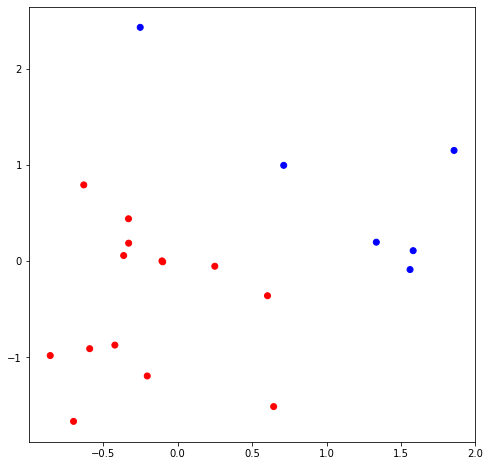

In [63]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], regres_data)), list(map(lambda x: x[1], regres_data)), 
              c=regres_values, cmap=colors)

In [64]:
from sklearn import model_selection

train_data, test_data, train_values, test_values = model_selection.train_test_split(regres_data, 
                                                                                     regres_values, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [65]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [73]:
class Leaf:
    
    def __init__(self, data, values):
        self.data = data
        self.values = values  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self): 
        prediction = np.mean(self.values)
        return prediction        

In [67]:
def vari (values):
    variation = np.var(values)        
    return variation

In [68]:
def quality(left_values, right_values, current_variation):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_values.shape[0]) / (left_values.shape[0] + right_values.shape[0])
    
    return current_variation - p * vari(left_values) - (1 - p) * vari(right_values)

In [69]:
def split(data, values, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_values = values[left]
    false_values = values[right]
        
    return true_data, false_data, true_values, false_values

In [140]:
def find_best_split(data, values):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 2

    current_variation = vari(values)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_values, false_values = split(data, values, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_values, false_values, current_variation)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [141]:
def build_tree(data, values):
    
    quality, t, index = find_best_split(data, values)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, values)
    
    true_data, false_data, true_values, false_values = split(data, values, index, t)
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_values)
    false_branch = build_tree(false_data, false_values)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [142]:
my_tree = build_tree(train_data, train_values)

In [143]:
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.6448475108927784
--> True:
  Индекс 0
  Порог -0.4225079291623943
  --> True:
    Индекс 0
    Порог -0.7001790376899514
    --> True:
      Прогноз: -10.586745423908184
    --> False:
      Прогноз: -6.980025097154961
  --> False:
    Индекс 0
    Порог -0.10593044205742323
    --> True:
      Индекс 1
      Порог 0.059144243219039896
      --> True:
        Прогноз: -3.041140920023635
      --> False:
        Прогноз: -1.9432373755837138
    --> False:
      Прогноз: 1.5922016142540076
--> False:
  Прогноз: 13.91532903159006


In [144]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [145]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [146]:
train_answers = predict(train_data, my_tree)

In [147]:
answers = predict(test_data, my_tree)

In [148]:
train_mse = np.mean((train_values - train_answers)**2)
train_mse

4.69618156959003

In [149]:
test_mse = np.mean((test_values - answers)**2)
test_mse

12.909083068026929

In [150]:
test_values

array([ 4.89511051, -3.15601478, -0.89252882,  4.17697241, 12.12528861,
       14.01161819])

In [139]:
answers

[-0.906996106128253,
 -7.766094615866888,
 2.004095740518832,
 1.1803074879891833,
 13.258357190918202,
 19.42256366763307]